In [1]:
#import libraries
# Importación de las librerías
import numpy as np
import pandas as pd
import datetime 
import time
import urllib
import sys
import winsound
import sqlalchemy as sa
from pandas.tseries.offsets import MonthEnd
from pandas.tseries.offsets import MonthBegin
import random
from io import BytesIO
import modulo_conn_sql as mcq
from prophet import Prophet
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from livelossplot import PlotLossesKeras
import keras.optimizers as opts
from keras import backend as K
from pickle import dump
from pickle import load
from scipy import stats
from scipy.stats import johnsonsu   
import warnings
warnings.filterwarnings('ignore')

print("libraries success")

libraries success


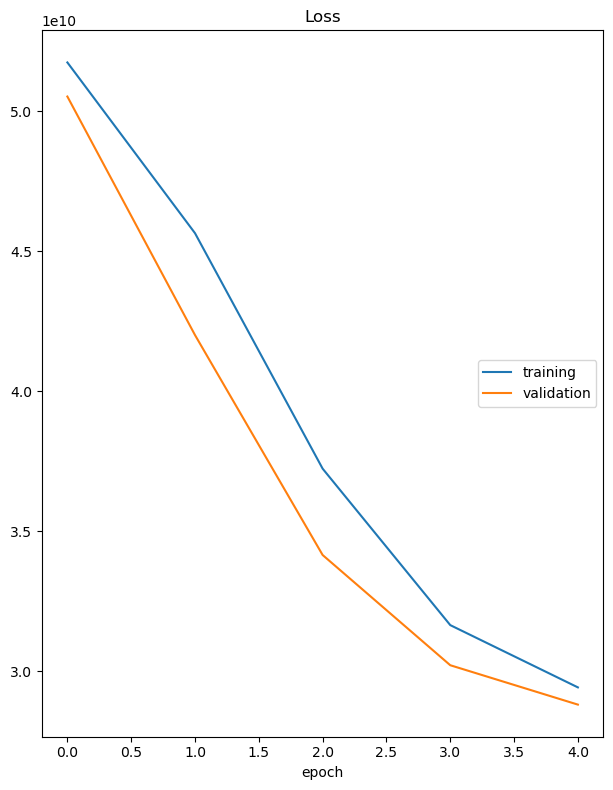

Loss
	training         	 (min: 29425743872.000, max: 51750100992.000, cur: 29425743872.000)
	validation       	 (min: 28810448896.000, max: 50532556800.000, cur: 28810448896.000)
42/42 [==============================] - 0s 973us/step
running EJECUCION DEL CIAP
294/294 [==============================] - 0s 795us/step


In [2]:

def play_error_alert():
    winsound.PlaySound(r'C:\Users\snortiz\Documents\projects\weekly_forecast\sounds\mixkit-wrong-answer-bass-buzzer-948.wav',winsound.SND_FILENAME)


def play_finished_alert():
    frequency = 1000  # Frequency of the finished alert sound
    duration = 500  # Duration of the sound in milliseconds
    winsound.Beep(frequency, duration)


################ RUN NEURAL NETWORK #################################




try:

    print("running neural network")

    # Metodos auxiliares
    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()


        return pd.DataFrame(resultadoSQL, columns = names)

    def get_dataset(
        procedure_name: str,
        param_pais: str,
        param_fecha_inicio: datetime,
        param_fecha_fin: datetime ) -> pd.core.frame.DataFrame:

        df = querySQL( 
            "{CALL " + procedure_name+ " (?,?,?)}", 
            ( 
                param_pais, 
                param_fecha_inicio.strftime("%Y-%m-%d"), 
                param_fecha_fin.strftime("%Y-%m-%d") 
            ) 
        )

        return df



    def split_train_test(
        param_df: pd.core.frame.DataFrame, 
        date_split:str ) -> (list, list):

        # Convertir dataframe a lista de listas, solo se toman las columnas desde el volumen
        dataset = param_df.iloc[: , 1:].values

        # definicion del conjunto de entrenamiento
        dataset_train = df[ df['Fecha'] < date_split ]
        dataset_train = dataset_train.iloc[:,2:].values

        # definicion del conjunto de test
        dataset_test = df[ df['Fecha'] >= date_split ]
        dataset_test = dataset_test.iloc[:,2:].values

        return (dataset_train, dataset_test)

    def scale_train_test(param_df, param_train, param_test ):

        dataset = param_df.iloc[: , 2:].values
        # Definicion de variable para escalar los datos entre 0 y 1
        sc = MinMaxScaler(feature_range = (0, 1))
        dataset = sc.fit(dataset)

        # Ajuste de los datos segun la variable escaladora
        dataset_train = sc.transform(param_train)
        dataset_test = sc.transform(param_test)

        # save the scaler
        dump(sc, open(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais + "/" + pais +'.pkl', 'wb'))

        return (dataset_train, dataset_test) 

    def train_model(
        param_dataset: list,
        timesteps : int,
        layers : int,
        units: int,
        dropout: float, 
        epochs: int, 
        batch: int,
        pais: str
    )-> None:

        predictor_variables_num = param_dataset.shape[1] #obtener numero de variables 

        #define array by predictor variable
        variables = [ [] for i in range(0, predictor_variables_num) ]
        X_train = []
        y_train = []

        for i in range(timesteps, param_dataset.shape[0] ):

            # process for each variable
            for j in range(0, predictor_variables_num):

                variables[j].append( param_dataset[i-timesteps:i, j] )

            y_train.append(param_dataset[i, 0])

        #convert to numpy objects
        for i in range(0, predictor_variables_num):
            variables[i] = np.array(variables[i])
        y_train = np.array(y_train)

        #reshape numpy objects
        for i in range(0, predictor_variables_num):
            variables[i] = np.reshape(variables[i], (variables[i].shape[0], variables[i].shape[1], 1 ))

        #build tensor structure for LSTM

        # if just one variable
        if predictor_variables_num == 1:
            X_train = variables[0]

        else:
            X_train = np.append(variables[0], (variables[1]), axis=2)

        # append to x_train if more than 2 variables
        if predictor_variables_num > 2:
            for i in range(2, predictor_variables_num):

                    X_train = np.append(X_train, (variables[i]), axis=2)

        #inizializate regressor
        regressor = Sequential()

        #if there is more than a layer, return input dimension to the next layer, through return_sequence parameter
        rs = True if layers > 1  else False

        print(X_train.shape)
        print(X_train.shape[1])
        print(X_train.shape[2])
        for i in range( 0, layers):

            # if the first layer, define input dimensions
            if i == 0:
                regressor.add(LSTM(units=units, return_sequences = rs, input_shape = (X_train.shape[1], X_train.shape[2])))
            else:
                regressor.add(LSTM(units=units, return_sequences = rs))

            #if dropout layers
            if dropout > 0.0:
                regressor.add(Dropout(dropout))

            # penultimate layer dont return input dimensions, because the last one just has 1 neuron
            if i == layers -2: 
                rs = False

        #output layer
        regressor.add(Dense(units=1))

        #compile RNR
        regressor.compile(optimizer = 'adam', loss='mean_squared_error')

        ##regressor.summary()

        #fit the RNR to datatrain
        regressor.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size = batch )

        #save model
        regressor.save(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais +"/" + pais + "_testing.h5")

    def test_model(
        param_train : list, 
        param_test: list, 
        test_no_scale : list,
        timesteps: int,
        pais: str ):

        predictor_variables_num = param_train.shape[1] #obtener cantidad de elementos dentro de cada dimension

        # load regressor in testing
        regressor_test = load_model(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais +"/" + pais + "_testing.h5")

        # load the scaler
        scaler = load(open(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais + "/" + pais + '.pkl', 'rb'))

        #inputs are last timesteps for first prediction day
        inputs = param_train[len(param_train) - timesteps: ]

        #this process will be excecute for every prediction day
        for j in range (0, param_test.shape[0] ):

            X_test = []
            #define array by predictor variable
            variables = [ [] for i in range(0, predictor_variables_num) ]

            for i in range(timesteps, inputs.shape[0]+1 ):

                # process for each variable
                for k in range(0, predictor_variables_num):

                    variables[k].append( inputs[i-timesteps:i, k] )

            #convert to numpy objects
            for i in range(0, predictor_variables_num):
                variables[i] = np.array(variables[i])

            #reshape numpy objects
            for i in range(0, predictor_variables_num):
                variables[i] = np.reshape(variables[i], (variables[i].shape[0], variables[i].shape[1], 1 ))


            #build tensor structure for LSTM
            # if just one variable
            if predictor_variables_num == 1:
                X_test = variables[0]

            else:
                X_test = np.append(variables[0], (variables[1]), axis=2)

            # append to x_test if more than 2 variables
            if predictor_variables_num > 2:
                for i in range(2, predictor_variables_num):

                    X_test = np.append(X_test, (variables[i]), axis=2)

            #make prediction
            prediction = regressor_test.predict(X_test)

            #to prediction append another regressor variables
            prediction = np.append(prediction, (param_test[:len(prediction), 1 : ]), axis=1 )

            inputs = param_train[len(param_train) - timesteps:]

            inputs = np.append(inputs, (prediction), axis=0 )


        print("MSE Test: "+str(mean_squared_error(prediction,param_test)))

        prediction = scaler.inverse_transform(prediction)

        return prediction


    def forecast(
        df_forecast: pd.core.frame.DataFrame,
        start_date_forecast : datetime ):

        dataset_pred = df_forecast[['DiaSemana','DiaSemana', 'Mes', 'Semana_Relativa', 'Semanas_mes', 'Año']]

        #convert to list
        predict_set = dataset_pred.iloc[:,:].values

        # load the scaler
        scaler = load(open(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais + "/" + pais + '.pkl', 'rb'))

        # load regressor in testing
        regressor_test = load_model(r"C:\Users\snortiz\Documents\projects\weekly_forecast\datos/" + pais +"/" + pais + "_testing.h5")

        #scale forecast dataset 
        predict_set_scaled = scaler.transform(predict_set)

        #define input dataset to start forecast
        dataset_test = df[ df['Fecha'] < start_date_forecast ]
        test_set  = dataset_test.iloc[:, 2:].values
        # scale features
        test_set_scaled = scaler.transform(test_set)

        #los inputs van a ser los ultimos Timesteps dias del training set, para predecir el primer dia 
        inputs = test_set_scaled[len(test_set_scaled) - timesteps: ]

        predictor_variables_num = predict_set_scaled.shape[1] 

        #this process will be excecute for every prediction day
        for j in range (0, predict_set_scaled.shape[0] ):
            X_test = []
            #define array by predictor variable
            variables = [ [] for i in range(0, predictor_variables_num) ]

            for i in range(timesteps, inputs.shape[0]+1 ):

                    # process for each variable
                    for k in range(0, predictor_variables_num):

                        variables[k].append( inputs[i-timesteps:i, k] )
            #convert to numpy objects
            for i in range(0, predictor_variables_num):
                variables[i] = np.array(variables[i])

            #reshape numpy objects
            for i in range(0, predictor_variables_num):
                variables[i] = np.reshape(variables[i], (variables[i].shape[0], variables[i].shape[1], 1 ))

            #build tensor structure for LSTM
            # if just one variable
            if predictor_variables_num == 1:
                X_test = variables[0]

            else:
                X_test = np.append(variables[0], (variables[1]), axis=2)

            #append to x_test if more than 2 variables
            if predictor_variables_num > 2:
                for i in range(2, predictor_variables_num):

                    X_test = np.append(X_test, (variables[i]), axis=2)     

            #make prediction
            prediction = regressor_test.predict(X_test)

            #to prediction append another regressor variables
            prediction = np.append(prediction, (predict_set_scaled[:len(prediction), 1 : ]), axis=1 )

            inputs = test_set_scaled[len(test_set_scaled) - timesteps:]

            inputs = np.append(inputs, (prediction), axis=0 )

        prediction = scaler.inverse_transform(prediction)

        return prediction

    #Run parameters for neural network
    #Parametros SQL
    pais = 'Colombia'  
    inicioHistoria = datetime.datetime(2013,1, 1) #'2013-05-01'
    finHistoria = datetime.datetime.today() #fecha actual
    fecha_split = finHistoria - datetime.timedelta(days=60)

    df = get_dataset("SCAC_AP4_Serie_VolumenDiario", pais, inicioHistoria, finHistoria)

    #SPLIT TRAIN - TEST
    dataset_train_nscale, dataset_test_nscale = split_train_test(df, fecha_split) 

    #SCALE VARIABLES
    dataset_train, dataset_test = scale_train_test(df, dataset_train_nscale,dataset_test_nscale ) 

    #TRAIN MODEL

    timesteps = 45
    layers = 2
    units = 3000
    dropout = 0.3
    epochs = 300
    batch = 24

    train_model(dataset_train, timesteps, layers, units, dropout, epochs, batch, pais)

    #Parameters for all forecast 

    start_date_forecast = datetime.datetime.today() + datetime.timedelta(days=1)
    end_date_forecast = start_date_forecast + datetime.timedelta(days=6)

    start_date_forecast_str = start_date_forecast.strftime("%Y-%m-%d")
    end_date_forecast_str = end_date_forecast.strftime("%Y-%m-%d")

    start_date_forecast_year = start_date_forecast.year



    df2 = get_dataset("SCAC_AP4_Serie_VolumenDiario_AuxFecha", pais, start_date_forecast, end_date_forecast)

    result = forecast(df2, start_date_forecast)

    #mensual results
    df_result = pd.DataFrame({'Forecast':result[:, 0]})
    df_result = pd.concat([df2, df_result], axis=1)

    neural_network_forecast_concret_value = df_result['Forecast'].sum()








    ############## RUN FACEBOOK PROPHET MODEL ####################









    print("facebook prophet")





    # Metodos auxiliares
    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    def get_dataset(
        procedure_name: str,
        param_pais: str,
        param_fecha_inicio: datetime,
        param_fecha_fin: datetime ) -> pd.core.frame.DataFrame:

        df = querySQL( 
            "{CALL " + procedure_name+ " (?,?,?)}", 
            ( 
                param_pais, 
                param_fecha_inicio.strftime("%Y-%m-%d"), 
                param_fecha_fin.strftime("%Y-%m-%d") 
            ) 
        )

        return df



    dias_pronostico = 10
    end_date_calendar = finHistoria + datetime.timedelta(days=dias_pronostico)


    df = df.sort_values(by="Fecha")
    df = df[['Fecha', 'Vol']]
    df.columns = ['ds', 'y']

    #run model
    #Creacion y ajuste del modelo
    m = Prophet(
        interval_width = 0.90,
        growth = 'linear',
        seasonality_mode = 'multiplicative',
        changepoint_prior_scale=30,
        seasonality_prior_scale=35,
        holidays_prior_scale=35,
        daily_seasonality=False,
        weekly_seasonality=False,
        yearly_seasonality=False,
        ).add_seasonality(
            name='monthly',
            period=30.5,
            fourier_order=10
        ).add_seasonality(
            name='weekly',
            period=7,
            fourier_order=75
        ).add_seasonality(
            name='yearly',
            period=365.25,
            fourier_order=90
        )

    m.fit(df)

    #pronostico
    future = m.make_future_dataframe(periods=dias_pronostico, freq = 'D')

    forecast = m.predict(future)
    df_real_prediccion = forecast[['ds','yhat']]

    df_real_prediccion = df_real_prediccion[df_real_prediccion['ds'] >= start_date_forecast_str]
    df_real_prediccion = df_real_prediccion[df_real_prediccion['ds'] <= end_date_forecast_str]

    prophet_forecast_concret_value = df_real_prediccion['yhat'].sum()

    #conseno entre ambos modelos
    
    print("RNR forecast: "+str(neural_network_forecast_concret_value))
    print("Prophet forecast: "+str(prophet_forecast_concret_value))
    forecast_concret_final = round((neural_network_forecast_concret_value+prophet_forecast_concret_value)/2,0)

    print("Final forecast is: "+str(forecast_concret_final))











    ######### RUN DAILY FORECAST #####################













    print("running daily forecast")



    #---------------------SQLALCHEMY CONNECTION---------------------------------
    params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
    engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params, fast_executemany=True)
    #---------------------------------------------------------------------------

    def send_df_to_sql(data,database_name):
        try:          
            data.to_sql(database_name, engine, index=False, if_exists="append", schema="dbo")  

            return "success"       
        except Exception as e:
            print(str(e))
            sys.exit()


    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    # dataset(pandas dataframe): base de datos con el historico
    # array_group_top(array) : array de la jerarquia mas ALTA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # array_group_bottom(array) : array de la jerarquia mas BAJA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # medida_target( string ) : nombre de la columna que contiene los datos objetivo de la proporcion
    # group_target(array) : array de nombre de columnas con las cuales queremos la proporcion final
    # name_proportion(string) : etiqueta de la dimension a la cual le estamos calculando la proporcion

    def historical_proportion( dataset, array_group_top, array_group_bottom, medida_target, group_target, name_proportion  ):

        promedio_group_top = dataset.groupby(array_group_top)[medida_target].mean().reset_index()

        promedio_group_bottom = dataset.groupby(array_group_bottom)[medida_target].mean().reset_index()    

        proportion  = pd.merge(promedio_group_bottom, promedio_group_top, how = 'inner', left_on = array_group_top, right_on = array_group_top )

        proportion['proportion'] = proportion[medida_target + '_x'] / proportion[medida_target + '_y']

        proportion = proportion.groupby(group_target)['proportion'].median().reset_index()

        proportion.rename(columns={'proportion':'proportion_' + name_proportion}, inplace = True)

        return proportion 

    def random_number (num):

        num = num if num <= 1 else 1

        return 1 + random.uniform( 0, num) if  random.random() < 0.5 else 1 - random.uniform( 0, num) 

    #desviacion estandar, media y coeficiente de variacion
    def stats_serie(dataset, array_group, colum_target):
        ret = dataset.groupby(array_group)[colum_target].agg( ['std', 'mean']).reset_index()
        ret['cov'] = ret['std']/ret['mean']

        return ret

    #PRINCIPAL PARAMETROS

    volPais = forecast_concret_final
    inicioHistoria = finHistoria - datetime.timedelta(days=730) #'2013-05-01'


    #Targets
    nivel_volatilidad = 0.0
    criterio_historia_reciente = 90 #dias

    version = "AUTO_SEMANAL"

    absorcionEstadistica = 1 #criterio para tomar las proporciones historicas de las plantas o False -> archivo que define el volumen por planta

    # FIN PARAMETROS 

    #Consulta de datos en la base SQL
    despachosSQL = querySQL(  "{CALL SCAC_AP8_BaseForecast (?,?,?)}", (pais, inicioHistoria.strftime("%Y-%m-%d"), finHistoria.strftime("%Y-%m-%d") ) )
    #despachosSQL = despachosSQL[despachosSQL['Planta']!= 'G014']
    calendarioLogistico = querySQL( "{CALL SCAC_AP9_CalendarioLogistico_auto (?,?,?)}" , (pais, start_date_forecast_str, end_date_forecast_str))
    #agrego informacion geografica        
    nombre_cluster = querySQL( "SELECT Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )

    #Otras Consultas
    irregularidades  = pd.read_excel(r"C:\Users\snortiz\OneDrive - CEMEX\Documentos\Proyectos\Proyectos-Cemex\Proyectos-Cemex\Desagregacion_Forecast\app\datos\BaseIrregularidades.xlsx")
    irregularidades['FechaEntrega'] = pd.to_datetime(irregularidades['FechaEntrega'])

    #arreglo de formatos
    despachosSQL['totalEntregado'] = despachosSQL['totalEntregado'].astype(float)
    calendarioLogistico['Dia_Semana'] = calendarioLogistico['Dia_Semana'].astype(int)

    #SOLO CENTROS ACTIVOS
    despachosSQL = pd.merge(despachosSQL,nombre_cluster[['Centro']], left_on='Planta', right_on='Centro' ).drop(columns=['Centro'])

    #irregularidades a nivel pais
    irr_nacional = irregularidades[irregularidades['Ciudad']==pais]
    despachos_irregularidades = pd.merge(despachosSQL, nombre_cluster, left_on='Planta', right_on='Centro')
    despachos_irregularidades = pd.merge(despachos_irregularidades, irr_nacional[['FechaEntrega','EtiquetaIrregularidad']], on='FechaEntrega', how='left')

    def generardor_desagregacion(despachosSQL, calendarioLogistico, absorcionEstadistica, criterio_historia_reciente, inicioHistoria, finHistoria, nivel_volatilidad, volPais, pais , despachos_irregularidades, irr_nacional):

        #Proporciones con toda la historia

        """NOTAS: se obetiene las proporciones a nivel general de los ultimos 30 dias de la fecha final de historia establecido en los parametros."""
        proportion_plant = historical_proportion(despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente))], ['Año', 'Mes'], ['Año', 'Mes', 'Planta'], 'totalEntregado', ['Planta'], 'planta')

        """NOTAS: se obetiene las proporciones a nivel de semana de toda la historia establecida en los parametros"""
        proportion_week = historical_proportion(despachosSQL, ['Año', 'Mes', 'Planta'], ['Año', 'Mes', 'Planta', 'Semana_Relativa'], 'totalEntregado', ['Planta', 'Semana_Relativa'], 'semana')

        """NOTAS: se obetiene las proporciones a nivel de semana de los ultimos 60 dias de la fecha final de historia establecido en los parametros."""
        proportion_week_recent = historical_proportion(despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente)) - MonthBegin(1) ], ['Año', 'Mes', 'Planta'], ['Año', 'Mes', 'Planta', 'Semana_Relativa'], 'totalEntregado', ['Planta', 'Semana_Relativa'], 'semana')

        """NOTAS: se obetiene las proporciones a nivel de dia de semana de toda la historia establecida en los parametros"""
        proportion_wday = historical_proportion(despachosSQL, ['Año', 'Mes', 'Planta'], ['Año', 'Mes', 'Planta', 'DiaSemana'], 'totalEntregado', ['Planta', 'DiaSemana'], 'dia_semana')

        """NOTAS: se obetiene las proporciones a nivel de dia de semana de los ultimos 60 dias de la fecha final de historia establecido en los parametros."""
        proportion_wday_recent = historical_proportion(despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente)) - MonthBegin(1) ], ['Año', 'Mes', 'Planta'], ['Año', 'Mes', 'Planta', 'DiaSemana'], 'totalEntregado', ['Planta', 'DiaSemana'], 'dia_semana')

        proportion_irr = historical_proportion(despachos_irregularidades, ['Planta'], [ 'Planta', 'EtiquetaIrregularidad'], 'totalEntregado', ['Planta', 'EtiquetaIrregularidad'], 'irregularidad')

        cov_plantas = stats_serie(despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente)) - MonthBegin(1) ], ['Planta'], 'totalEntregado')

        cov_planta_diasemana = stats_serie(despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente)) - MonthBegin(1) ], ['Planta', 'DiaSemana'], 'totalEntregado')

            #--------------- ESTIMACION DESAGREGACION FORECAST POR PLANTA ---------------# 

        if absorcionEstadistica == 1:
            #obtengo el listado de plantas que han estado activas los ultimos N dias
            DesagregacionPronosticoPlanta = despachosSQL[despachosSQL['FechaEntrega'] >= (finHistoria - datetime.timedelta(criterio_historia_reciente)) - MonthBegin(1) ]
            DesagregacionPronosticoPlanta = pd.DataFrame({'Planta' : DesagregacionPronosticoPlanta["Planta"].unique()})
            #se divide el volumen por igual en cada planta
            DesagregacionPronosticoPlanta['M3ForecastPlanta'] = volPais / DesagregacionPronosticoPlanta['Planta'].count()

            #join con proporcion planta
            DesagregacionPronosticoPlanta = pd.merge(DesagregacionPronosticoPlanta, proportion_plant, how='left', left_on=['Planta'], right_on=['Planta'] ).fillna(1)
            #join con proporcion planta
            DesagregacionPronosticoPlanta = pd.merge(DesagregacionPronosticoPlanta, cov_plantas, how='left', left_on=['Planta'], right_on=['Planta'] ).fillna(1)
            #DesagregacionPronosticoPlanta['Aleatorio_planta'] = DesagregacionPronosticoPlanta['cov'].apply( random_number) * nivel_volatilidad

            #se itera con las proporciones y se ajusta el resultado hasta que el gap sea menor a 1
            gap_iteracion = 1000.0
            while( abs(gap_iteracion) > 1 ):
                #print('iteracion Planta: ' + str(gap_iteracion) )
                DesagregacionPronosticoPlanta['forecast_planta'] = DesagregacionPronosticoPlanta['M3ForecastPlanta'] *  DesagregacionPronosticoPlanta['proportion_planta'] # *  DesagregacionPronosticoPlanta['Aleatorio_planta'] 
                resultado_iteracion = DesagregacionPronosticoPlanta['forecast_planta'].sum()
                gap_iteracion = resultado_iteracion - volPais
                DesagregacionPronosticoPlanta['M3ForecastPlanta'] = DesagregacionPronosticoPlanta['M3ForecastPlanta'] - (gap_iteracion / DesagregacionPronosticoPlanta['Planta'].count() )

            DesagregacionPronosticoPlanta = DesagregacionPronosticoPlanta[['Planta','forecast_planta']]



        #cross join tabla DesagregacionPronostico y calendario
        calendarioLogistico['key'] = 1
        DesagregacionPronosticoPlanta['key'] = 1
        DesagregacionPronosticoPlantaDia = pd.merge(calendarioLogistico, DesagregacionPronosticoPlanta, on = 'key').drop("key",1)

        #join con proporcion semana y semana reciente
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, proportion_week, how='left', left_on=['Planta','Semana_relativa'], right_on=['Planta','Semana_Relativa'] ).fillna(1)
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, proportion_week_recent, how='left', left_on=['Planta','Semana_relativa'], right_on=['Planta','Semana_Relativa'] ).fillna(1)

        #join con proporcion dia semana y dia semana reciente
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, proportion_wday, how='left', left_on=['Planta','Dia_Semana'], right_on=['Planta','DiaSemana'] ).fillna(1)
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, proportion_wday_recent, how='left', left_on=['Planta','Dia_Semana'], right_on=['Planta','DiaSemana'] ).fillna(1)
        DesagregacionPronosticoPlantaDia.head()

        #join con base de irregularidades para agregar etiqueta
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, irr_nacional[['FechaEntrega', 'EtiquetaIrregularidad']], how='left', left_on='Fecha de entrega', right_on='FechaEntrega' )

        #join con proporcion irregularidades
        DesagregacionPronosticoPlantaDia = pd.merge(DesagregacionPronosticoPlantaDia, proportion_irr, how='left', left_on=['Planta','EtiquetaIrregularidad'], right_on=['Planta','EtiquetaIrregularidad'] ).fillna(1)

        #join con el coeficiente de variabilidad
        DesagregacionPronosticoPlantaDia  = pd.merge(DesagregacionPronosticoPlantaDia , cov_planta_diasemana, how='left', left_on=['Planta', 'Dia_Semana'], right_on=['Planta','DiaSemana'] )

        #quito columnas que no me interesan
        DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("DiaSemana_x",1)
        DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("DiaSemana_y",1)
        DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("Semana_Relativa_x",1)
        DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("Semana_Relativa_y",1) 

        #se agrega aleatoriedad a la desagregacion
        DesagregacionPronosticoPlantaDia['Aleatorio'] = DesagregacionPronosticoPlantaDia['cov'].apply( random_number) * nivel_volatilidad

        #SETUP MATRIZ DE ITERACIONES
        #DesagregacionPronosticoPlantaDia['M3Forecast'] = (DesagregacionPronosticoPlantaDia['Días_Operativos'] * ( DesagregacionPronosticoPlantaDia['forecast_planta'] / DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes']) * DesagregacionPronosticoPlantaDia['proportion_semana'] * DesagregacionPronosticoPlantaDia['proportion_dia_semana']  ).astype(float)
        DesagregacionPronosticoPlantaDia['M3Forecast'] =  (DesagregacionPronosticoPlantaDia['Días_Operativos'] * \
                                                           ( DesagregacionPronosticoPlantaDia['forecast_planta'] / DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes']) * \
                                                           DesagregacionPronosticoPlantaDia['proportion_semana_x'] * \
                                                           DesagregacionPronosticoPlantaDia['proportion_dia_semana_y'] * \
                                                           DesagregacionPronosticoPlantaDia['proportion_irregularidad'] * \
                                                           DesagregacionPronosticoPlantaDia['Aleatorio'] ).astype(float)

        matrizPPTO_Resultado = pd.DataFrame(DesagregacionPronosticoPlantaDia.groupby('Planta')['M3Forecast'].sum()).reset_index()
        matrizPPTO_Resultado = pd.merge(matrizPPTO_Resultado, DesagregacionPronosticoPlanta, on = 'Planta' ).drop("key",1)
        matrizPPTO_Resultado['gap'] = matrizPPTO_Resultado['M3Forecast'] - matrizPPTO_Resultado['forecast_planta']
        matrizPPTO_Resultado['ResultadoIteracion'] = matrizPPTO_Resultado['M3Forecast']
        matrizPPTO_Resultado['M3Forecast'] = matrizPPTO_Resultado['forecast_planta'] - matrizPPTO_Resultado['gap']

        gapTotal = matrizPPTO_Resultado['gap'].abs().sum()

        
        while( gapTotal > 1 ):

            #print(str(gapTotal) )

            for index, row in matrizPPTO_Resultado.iterrows():
                DesagregacionPronosticoPlantaDia.loc[DesagregacionPronosticoPlantaDia['Planta'] == row['Planta'], ['forecast_planta']] = row['M3Forecast']

            #DesagregacionPronosticoPlantaDia['M3Forecast'] = ((DesagregacionPronosticoPlantaDia['forecast_planta'] / volPais ) * (DesagregacionPronosticoPlantaDia['Días_Operativos'] * ( DesagregacionPronosticoPlantaDia['forecast_planta'] / DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes']) * DesagregacionPronosticoPlantaDia['proportion_semana'] * DesagregacionPronosticoPlantaDia['proportion_dia_semana'])).astype(float)
            DesagregacionPronosticoPlantaDia['M3Forecast'] = (#(DesagregacionPronosticoPlantaDia['forecast_planta'] / volPais ) *
                                                               DesagregacionPronosticoPlantaDia['Días_Operativos'] * 
                                                               (DesagregacionPronosticoPlantaDia['forecast_planta'] / DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes']) * 
                                                               DesagregacionPronosticoPlantaDia['proportion_semana_x'] * 
                                                               #DesagregacionPronosticoPlantaDia['proportion_semana_y']  *  
                                                               DesagregacionPronosticoPlantaDia['proportion_dia_semana_x'] #*
                                                               #DesagregacionPronosticoPlantaDia['proportion_dia_semana_y'] 
                                                               #* DesagregacionPronosticoPlantaDia['proportion_irregularidad']
                                                               #* DesagregacionPronosticoPlantaDia['Aleatorio']
                                                               #* DesagregacionPronosticoPlantaDia['cov']
                                                               ).astype(float) #+ (DesagregacionPronosticoPlantaDia['Días_Operativos'] * DesagregacionPronosticoPlantaDia['Aleatorio'] * (DesagregacionPronosticoPlantaDia['forecast_planta'] / DesagregacionPronosticoPlantaDia['Total_Dias_Habiles_Mes']))


            matrizTemp = pd.DataFrame(DesagregacionPronosticoPlantaDia.groupby('Planta')['M3Forecast'].sum()).reset_index()

            for index, row in matrizTemp.iterrows():
                matrizPPTO_Resultado.loc[matrizPPTO_Resultado['Planta'] == row['Planta'], ['ResultadoIteracion']] = row['M3Forecast']

            matrizPPTO_Resultado['gap'] = matrizPPTO_Resultado['ResultadoIteracion'] - matrizPPTO_Resultado['forecast_planta']
            matrizPPTO_Resultado['M3Forecast'] = matrizPPTO_Resultado['M3Forecast'] - matrizPPTO_Resultado['gap']

            gapTotal = matrizPPTO_Resultado['gap'].abs().sum()

            DesagregacionPronosticoPlantaDia = DesagregacionPronosticoPlantaDia.drop("forecast_planta",1)   




        return DesagregacionPronosticoPlantaDia


    #ejecutar n veces la desagregacion

    for i in range (0, 10):
        for j in range(0, 1):
            temp = generardor_desagregacion(despachosSQL, calendarioLogistico, absorcionEstadistica, ((j + 1) * 30) , inicioHistoria, finHistoria, nivel_volatilidad, volPais, pais, despachos_irregularidades, irr_nacional )
            temp['Version'] = str(i)
            if i == 0 :
                desagregacion_temp = temp
            else :
                desagregacion_temp = pd.concat([desagregacion_temp, temp])

    df_result = pd.merge (desagregacion_temp, nombre_cluster, how='left', left_on='Planta', right_on='Centro')
    df_result = df_result[['pais','Ciudad', 'Centro', 'PlantaUnica', 'Fecha de entrega', 'M3Forecast', 'proportion_semana_x','proportion_dia_semana_y','proportion_irregularidad', 'Cluster']]

    #df_result = df_result.groupby(['pais','Ciudad', 'Centro', 'PlantaUnica', 'Fecha de entrega', 'Cluster']).agg({'M3Forecast': 'mean'}).reset_index()
    df_result = df_result.groupby(['pais','Ciudad', 'Centro', 'PlantaUnica', 'Fecha de entrega']).agg({'M3Forecast': 'mean'}).reset_index().fillna(0)
    #df_result = df_result.groupby(['pais','Ciudad', 'Centro', 'PlantaUnica', 'Fecha de entrega','proportion_semana_x','proportion_dia_semana_y','proportion_irregularidad']).agg({'M3Forecast': 'mean'}).reset_index()


    #Cargar desagregado a sql SOLO CUANDO SE CONFIRMA QUE EL DESAGREGADO ESTA VALIDO
    #declarar la version, mes y año correspondiente
   
    database_name = 'SCAC_AV7_DesagregacionPronosticoCiudadPlantaDiaTabla' #no cambiar
    #database_name = 'desagregadocopy'
    #rename columns to sql columns
    df_result = df_result.rename(columns={
        'pais': 'Pais', 
        'Fecha de entrega': 'FechaEntrega'})
    df_result['Version'] = version

    print("---------------------------------")
    print("sending daily forecast to sql")
    send_df_to_sql(df_result,database_name)








    ################### RUN FORECAST FOR MMPP ############################### 






    print("running parameters update")
    #ACTUALIZAR PARAMETROS





    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    def generar_parametros_materiales(inicio_param, fin_param, pais_param):

        lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

        #Dataset de los consumos
        df = querySQL( "SELECT * FROM AT51_Z1045_CONSU_TICKET2 WHERE FechaInicio between ? and ?" , (inicio_param.strftime("%Y-%m-%d"), fin_param.strftime("%Y-%m-%d") ) )
        df['year_month'] = df.FechaInicio.dt.to_period('M')
        df['TipoMaterial'] = df['TipoMaterial'].str.strip()
        df['TextoBreveMaterial'] = df['TextoBreveMaterial'].str.strip()

        #agrego informacion geografica        
        nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
        cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()


        #Dataset de los despachos
        df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais_param, inicio_param.strftime("%Y-%m-%d"), fin_param.strftime("%Y-%m-%d")) )
        df_serv = df_serv.fillna(value=np.nan)
        df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')
        #df_serv[['DescTecnica1', 'DescTecnica2', 'DescTecnica3', 'DescTecnica4', 'DescTecnica5', 'DescTecnica6', 'DescTecnica7', 'DescTecnica8', 'DescTecnica9']] = df_serv['DescTecnica'].str.split("-", expand=True) 

        #union con el dataframe de Despacho para obtener informacion de volumen y descripcion tecnica
        df1 = pd.merge(df, df_serv[['Cluster', 'Planta', 'Ciudad' ,'Entrega', 'VolPartida', 'TipoProducto']], on='Entrega')
        df1 = df1[df1['VolPartida'] > 0.0]
        df1['cantidad_por_m3'] = np.where( df1['VolPartida'] > 0.0, df1['CantidadReal']/df1['VolPartida'], 0)
        df1['cantidad_por_m3'] = df1['cantidad_por_m3'].astype(float)

        df1 = df1[df1['cantidad_por_m3'] > 0]


        #re categorizacion de materiales
        df1['TipoMaterial2'] = np.select(
            [
                (df1['TextoBreveMaterial'].str.contains('CEMENTO,BLANCO')) | (df1['TextoBreveMaterial'].str.contains('CEM ART')) | (df1['TextoBreveMaterial'].str.contains('CEM GRIS')),
                (df1['TextoBreveMaterial'].str.contains('CENIZA')),
                (df1['TextoBreveMaterial'].str.contains('GRAVA')),
                (df1['TextoBreveMaterial'].str.contains('ARENA')),
                (df1['TipoMaterial'].str.contains('ADI')),
                (df1['TipoMaterial'].str.contains('ADC')),
                #(df1['TipoMaterial'].str.contains('FIB')),
                (df1['TipoMaterial'].str.contains('AGU'))
            ],
            [

                'CEMENTO',
                'CENIZA',
                'GRAVA',
                'ARENA',
                'ADITIVO',
                'OTROS',
                #'FIBRA',
                'Agua'
            ], default = 'OTROS'#df1['TextoBreveMaterial']
        )

        df2 = pd.pivot_table(
            df1,
            index = ['Cluster', 'Planta', 'Ciudad','Entrega','TipoProducto'],
            columns =['TipoMaterial2'],
            values = ['cantidad_por_m3'],
            aggfunc = np.sum
        ).reset_index().set_axis(['Cluster','Planta', 'Ciudad','Entrega','TipoProducto', 'ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA', 'OTROS'], axis=1, inplace=False)

        # Definición de la distribución
        distribucion = stats.johnsonsu
        df_parametros = pd.DataFrame()

        for i in cluster_planta.values:

            for j in range(0, len(lista_materiales)):
                datos = df2[df2['Planta'] == i[1]][[lista_materiales[j]]]
                datos = datos.loc[datos[lista_materiales[j]].notnull()]

                if (len(datos) > 0):
                    # Ajuste para obtener el valor de los parámetros
                    parametros = distribucion.fit(datos.to_numpy()) 
                    parametros = [*parametros]

                dict_param = {'ubicacion': i[1], 'material': lista_materiales[j] ,'param1':parametros[0], 'param2':parametros[1], 'param3':parametros[2], 'param4':parametros[3] }

                if len(df_parametros) == 0:
                    df_parametros = pd.DataFrame.from_dict([dict_param])
                else: 
                    df_parametros = df_parametros.append([dict_param], ignore_index = True)

        try:
            params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01; \
                DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
            engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params, fast_executemany=True)

            df_parametros.to_sql("SCAC_AT42_parametros_distribucion_materiales", engine, 
                                 index=False, if_exists="replace", schema="dbo")
        except Exception as e:
            print(e)

    #PARAMETROS

    fin_historia = finHistoria # fecha maxima de consulta
    inicio_historia= fin_historia - MonthBegin(6) # fecha maxima menos n meses de historia

    generar_parametros_materiales(inicio_historia, fin_historia, pais)


    
    
    



    #MANTENIMIENTO DATATRAINING
    print("running dataset maintenece")


    

    

    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    #SQL Methods to get operation data
    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    # dataset(pandas dataframe): base de datos con el historico
    # array_group_top(array) : array de la jerarquia mas ALTA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # array_group_bottom(array) : array de la jerarquia mas BAJA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # medida_target( string ) : nombre de la columna que contiene los datos objetivo de la proporcion
    # group_target(array) : array de nombre de columnas con las cuales queremos la proporcion final
    # name_proportion(string) : etiqueta de la dimension a la cual le estamos calculando la proporcion

    def historical_proportion( dataset, array_group_top, array_group_bottom, medida_target, group_target, name_proportion  ):

        promedio_group_top = dataset.groupby(array_group_top)[medida_target].mean().reset_index()
        promedio_group_bottom = dataset.groupby(array_group_bottom)[medida_target].mean().reset_index()    
        proportion  = pd.merge(promedio_group_bottom, promedio_group_top, how = 'inner', left_on = array_group_top,
                               right_on = array_group_top )
        proportion['proportion'] = proportion[medida_target + '_x'] / proportion[medida_target + '_y']
        proportion = proportion.groupby(group_target)['proportion'].mean().reset_index()
        proportion.rename(columns={'proportion':'proportion_' + name_proportion}, inplace = True)

        return proportion 

    def build_datatraining(pais, fecha_inicio, fecha_fin, fecha_split):
        #Dataset de consu_ticket
        df_consuticket = querySQL( "{CALL SCAC_AP20_CONSU_TICKET_DIARIO (?,?,?)}" , (pais, fecha_inicio, fecha_fin) )
        df_consuticket['Centro'] = df_consuticket['Centro'].str.strip()
        df_consuticket['TipoMaterial'] = df_consuticket['TipoMaterial'].str.strip()
        df_consuticket['TextoBreveMaterial'] = df_consuticket['TextoBreveMaterial'].str.strip()

        # Dataset calendario
        df_calendario = querySQL( "SELECT * FROM SCAC_AT3_DiasHabilesFuente WHERE pais = ? and [Fecha de entrega]  \
        between ? and ?" , (pais, fecha_inicio, fecha_fin))
        df_calendario.rename(columns={'Fecha de entrega':'FechaEntrega'}, inplace =True)

        #Dataset de los despachos por entrega
        df_serv = querySQL( "{CALL SCAC_AP10_dataset_servicios_rango (?,?,?)}" , (pais, fecha_inicio, fecha_fin) )
        df_serv = df_serv.fillna(value=np.nan)
        df_serv['year_month'] = df_serv.FechaEntrega.dt.to_period('M')

        #Agrupacion del volumen a nivel diario y por planta unica
        df_volumen = df_serv[(df_serv['Entrega'] != '') & (df_serv['Estatus'] == 'Normal') ].groupby(['Planta','FechaEntrega'])\
        ['VolPartida'].agg(['sum']).reset_index()
        df_volumen.rename(columns={'sum':'VolumenConcreto'}, inplace =True)

        df_consuticketdiario = df_consuticket[df_consuticket['CantidadReal'] > 0]\
        .groupby(['FechaInicio', 'Pais', 'Cluster', 'Planta', 'TipoMaterial',
               'TextoBreveMaterial',]).agg({'CantidadReal':'sum'}).reset_index()

        #Union de los dataset de mmpp, concreto y calendario
        df_total = pd.merge(df_consuticketdiario, df_volumen, left_on=['Planta', 'FechaInicio'], right_on=['Planta','FechaEntrega'])
        df_total = pd.merge(df_total, df_calendario, on=['FechaEntrega'])
        df_total['year_month'] = df_total.FechaEntrega.dt.to_period('M')

        ######################################################################
        ############### CALCULO DE VARIABLES PREDICTORAS  ####################
        ######################################################################

        # Volumen(TN, L) por cantidad de material
        df_tipoMaterial = df_total.groupby(['Planta','TipoMaterial','FechaEntrega'])['CantidadReal'].sum().reset_index()
        df_tipoMaterial.rename(columns={'CantidadReal':'VolumenTipoMaterial'}, inplace = True)   

        #proporcion de Material
        df_proportion_material = pd.DataFrame()

        for i in df_total['year_month'].unique():

            mes =  df_total[df_total['year_month'] == i]['Mes'].unique()[0]
            año =  df_total[df_total['year_month'] == i]['Año'].unique()[0]

            df_param = df_total[(df_total['FechaInicio'] >= datetime.datetime(año, mes , 1) - MonthBegin(2)) & \
                                (df_total['FechaInicio'] < datetime.datetime(año, mes , 1))]
            if len(df_param) > 0:
                proportion_detalle_material = historical_proportion(df_param,['Año', 'Mes', 'Planta', 'TipoMaterial'], \
                                                                    ['Año', 'Mes', 'Planta', 'TipoMaterial', 'TextoBreveMaterial']\
                                                                    , 'CantidadReal',['Planta', 'TextoBreveMaterial'], \
                                                                    'material_detalle'  )
                proportion_detalle_material['Año'] = año
                proportion_detalle_material['Mes'] = mes
                if len(df_proportion_material) == 0:
                    df_proportion_material = proportion_detalle_material
                else:
                    df_proportion_material = pd.concat([df_proportion_material, proportion_detalle_material])

        df_proportion_material = df_proportion_material.fillna(0)

        #proporcion de Semana
        df_proportion_semana = pd.DataFrame()

        for i in df_total['year_month'].unique():

            mes =  df_total[df_total['year_month'] == i]['Mes'].unique()[0]
            año =  df_total[df_total['year_month'] == i]['Año'].unique()[0]

            df_param = df_total[(df_total['FechaInicio'] >= datetime.datetime(año, mes , 1) - MonthBegin(2)) &  (df_total['FechaInicio'] < datetime.datetime(año, mes , 1))]
            if len(df_param) > 0:
                df_proportion_semana_detalle = historical_proportion(df_param,['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], ['Año', 'Mes', 'Planta', 'TextoBreveMaterial', 'Semana_relativa'], 'CantidadReal',['Planta', 'TextoBreveMaterial', 'Semana_relativa'], 'semana_detalle'  )
                df_proportion_semana_detalle['Año'] = año
                df_proportion_semana_detalle['Mes'] = mes
                if len(df_proportion_semana_detalle) == 0:
                    df_proportion_semana = df_proportion_semana_detalle
                else:
                    df_proportion_semana = pd.concat([df_proportion_semana, df_proportion_semana_detalle])

        df_proportion_semana = df_proportion_semana.fillna(0)

        #proporcion de Dia Semana
        df_proportion_diasemana = pd.DataFrame()

        for i in df_total['year_month'].unique():

            mes =  df_total[df_total['year_month'] == i]['Mes'].unique()[0]
            año =  df_total[df_total['year_month'] == i]['Año'].unique()[0]

            df_param = df_total[(df_total['FechaInicio'] >= datetime.datetime(año, mes , 1) - MonthBegin(2)) &  (df_total['FechaInicio'] < datetime.datetime(año, mes , 1))]
            if len(df_param) > 0:
                df_proportion_diasemana_detalle = historical_proportion(df_param,['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], ['Año', 'Mes', 'Planta', 'TextoBreveMaterial', 'Dia_Semana'], 'CantidadReal',['Planta', 'TextoBreveMaterial', 'Dia_Semana'], 'diasemana_detalle'  )
                df_proportion_diasemana_detalle['Año'] = año
                df_proportion_diasemana_detalle['Mes'] = mes
                if len(df_proportion_diasemana_detalle) == 0:
                    df_proportion_diasemana = df_proportion_diasemana_detalle
                else:
                    df_proportion_diasemana = pd.concat([df_proportion_diasemana, df_proportion_diasemana_detalle])

        df_proportion_diasemana = df_proportion_diasemana.fillna(0)

        #Volumen mes anterior
        df_mes_anterior = pd.DataFrame()

        for i in df_total['year_month'].unique():

            mes =  df_total[df_total['year_month'] == i]['Mes'].unique()[0]
            año =  df_total[df_total['year_month'] == i]['Año'].unique()[0]

            df_param = df_total[(df_total['FechaEntrega'] >= datetime.datetime(año, mes , 1) - MonthBegin(1)) &  (df_total['FechaEntrega'] < datetime.datetime(año, mes , 1))]
            df_param = df_param.groupby(['Planta', 'TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
            df_param.rename(columns={'CantidadReal':'VolumenMesAnterior'}, inplace = True)
            #df_param['VolumenMesAnterior'] =  df_param['VolumenMesAnterior'] 
            df_param['Año'] = año
            df_param['Mes'] = mes

            if len(df_mes_anterior) == 0:
                df_mes_anterior = df_param
            else:
                df_mes_anterior = pd.concat([df_mes_anterior, df_param])

        #Volumen de hace 2 meses
        df_mes_anterior2 = pd.DataFrame()

        for i in df_total['year_month'].unique():

            mes =  df_total[df_total['year_month'] == i]['Mes'].unique()[0]
            año =  df_total[df_total['year_month'] == i]['Año'].unique()[0]

            df_param = df_total[(df_total['FechaEntrega'] >= datetime.datetime(año, mes , 1) - MonthBegin(2)) &  (df_total['FechaEntrega'] < datetime.datetime(año, mes , 1)  - MonthBegin(1)) ]
            df_param = df_param.groupby(['Planta', 'TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
            df_param.rename(columns={'CantidadReal':'VolumenMesAnterior2'}, inplace = True)
            #df_param['VolumenMesAnterior'] =  df_param['VolumenMesAnterior'] 
            df_param['Año'] = año
            df_param['Mes'] = mes

            if len(df_mes_anterior2) == 0:
                df_mes_anterior2 = df_param
            else:
                df_mes_anterior2 = pd.concat([df_mes_anterior2, df_param])


        df = pd.merge(df_total,df_tipoMaterial, on=['FechaEntrega', 'Planta','TipoMaterial'], how='left' )

        df = pd.merge(df, df_proportion_material, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], how='left')

        df = pd.merge(df, df_proportion_semana, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial','Semana_relativa'], how='left')

        df = pd.merge(df, df_proportion_diasemana, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial','Dia_Semana'], how='left')

        df = pd.merge(df, df_mes_anterior, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], how='left')

        df = pd.merge(df, df_mes_anterior2, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], how='left')

        ## queda pendiente decidir que es mejor para imputar valores
        """
        df['proportion_material_detalle'] = df['proportion_material_detalle'].fillna(df['proportion_material_detalle'].median())
        df['proportion_semana_detalle'] = df['proportion_semana_detalle'].fillna(df['proportion_semana_detalle'].median())
        df['proportion_diasemana_detalle'] = df['proportion_diasemana_detalle'].fillna(df['proportion_diasemana_detalle'].median())

        df['VolumenConcreto'] = df['VolumenConcreto'].fillna(df['VolumenConcreto'].median())
        df['VolumenMesAnterior'] = df['VolumenMesAnterior'].fillna(df['VolumenMesAnterior'].median())
        df['VolumenMesAnterior2'] = df['VolumenMesAnterior2'].fillna(df['VolumenMesAnterior2'].median())
        """

        df['proportion_material_detalle'] = df['proportion_material_detalle'].fillna(0)
        df['proportion_semana_detalle'] = df['proportion_semana_detalle'].fillna(0)
        df['proportion_diasemana_detalle'] = df['proportion_diasemana_detalle'].fillna(0)

        df['VolumenConcreto'] = df['VolumenConcreto'].fillna(0)
        df['VolumenMesAnterior'] = df['VolumenMesAnterior'].fillna(0)
        df['VolumenMesAnterior2'] = df['VolumenMesAnterior2'].fillna(0)

        df_train = df[(df['TipoMaterial'] != 'AGU') & (df['FechaEntrega'] >= fecha_split )]

        columnas_finales = ['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais',
               'proportion_material_detalle', 'proportion_semana_detalle',
               'proportion_diasemana_detalle', 'CantidadReal', 'Año', 'Mes',
               'Dia_Semana', 'Semana_relativa', 'VolumenConcreto',
               'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']


        dataTraining = df_train[columnas_finales]

        return dataTraining

    #PARAMETROS
    pais_param = pais

    fecha_inicio_param = datetime.datetime.today() - datetime.timedelta(days=365) # esta fecha debe ser al menos 3 mese antes del fecha_split_param
    
    #esta fecha se incluye
    #se define una fecha split ya que se nececita informacion de meses anteriores para calcular las variables predictoras
    fecha_fin_param = datetime.datetime.today()
    fecha_split_param = fecha_fin_param - datetime.timedelta(days=45)
    fecha_split_param = fecha_split_param.strftime("%Y-%m-%d")
    fecha_fin_param = fecha_fin_param.strftime("%Y-%m-%d")
    fecha_inicio_param = fecha_inicio_param.strftime("%Y-%m-%d")
    
    
    df_actualizar_training = build_datatraining(pais_param, fecha_inicio_param, fecha_fin_param, fecha_split_param)

  

    params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
    engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params, fast_executemany=True)

    df_actualizar_training.to_sql("SCAC_AT46_ciap_mmpp", engine, index=False, if_exists="replace", schema="dbo")

    
    
    
    
    


    #RE-ENTRENAMIENTO MODELOS PREDICTIVOS

    print("running RE-ENTRENAMIENTO MODELOS PREDICTIVOS")



    
    
    
    
    
    
    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    #SQL Methods to get operation data
    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor


    # Selecciono el dataset almacenado en el SQL

    df = querySQL( "SELECT * FROM SCAC_AT46_ciap_mmpp" , () )

    #ajuste de formatos
    df['proportion_material_detalle'] = df['proportion_material_detalle'].astype(float)
    df['proportion_semana_detalle'] = df['proportion_semana_detalle'].astype(float)
    df['proportion_diasemana_detalle'] = df['proportion_diasemana_detalle'].astype(float)
    df['CantidadReal'] = df['CantidadReal'].astype(float)
    df['VolumenConcreto'] = df['VolumenConcreto'].astype(float)
    df['VolumenTipoMaterial'] = df['VolumenTipoMaterial'].astype(float)
    df['VolumenMesAnterior'] = df['VolumenMesAnterior'].astype(float)
    df['VolumenMesAnterior2'] = df['VolumenMesAnterior2'].astype(float)
    df['Año'] = df['Año'].astype(int)
    df['Mes'] = df['Mes'].astype(int)
    df['Dia_Semana'] = df['Dia_Semana'].astype(int)
    df['Semana_relativa'] = df['Semana_relativa'].astype(int)

    # dataframe auxiliar para codificar variables categoricas
    df_encoding_1 = df[['TipoMaterial', 'Planta', 'Cluster', 'Pais']]

    # dataframe auxiliar especifico para codificar texto breve material ordenado de menor a mayor por la suma de su volumen
    df_encoding_2 = df.groupby(['TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
    df_encoding_2 = df_encoding_2.sort_values(by=['CantidadReal']).reset_index(drop = True)


    # declaracion de label encoders
    le_tipoMaterial = preprocessing.LabelEncoder()
    le_textoBreveMaterial = preprocessing.LabelEncoder()
    le_planta = preprocessing.LabelEncoder()
    le_cluster = preprocessing.LabelEncoder()
    le_pais = preprocessing.LabelEncoder()

    # fit transform de los label encoders
    df_encoding_1['TipoMaterial'] = le_tipoMaterial.fit_transform(df_encoding_1['TipoMaterial'])

    df_encoding_1['Planta'] = le_planta.fit_transform(df_encoding_1['Planta'])
    df_encoding_1['Cluster'] = le_cluster.fit_transform(df_encoding_1['Cluster'])
    df_encoding_1['Pais'] = le_pais.fit_transform(df_encoding_1['Pais'])

    df_encoding_2['TextoBreveMaterial'] = le_textoBreveMaterial.fit_transform(df_encoding_2['TextoBreveMaterial'])

    # se guardan los label encoders
    dump(le_tipoMaterial, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_tipoMaterial.pkl', 'wb'))
    dump(le_textoBreveMaterial, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_textoBreveMaterial.pkl', 'wb'))
    dump(le_planta, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_planta.pkl', 'wb'))
    dump(le_cluster, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_cluster.pkl', 'wb'))
    dump(le_pais, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_pais.pkl', 'wb'))

    # escalamiento de variables numericas
    num_vars = ['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']
    values_scaled = df[num_vars].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(values_scaled)

    #se guarda el escalador
    dump(min_max_scaler, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/min_max_scaler.pkl', 'wb'))

    dataTraining = pd.concat([
        df[['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais','proportion_material_detalle', 'proportion_semana_detalle','proportion_diasemana_detalle', 'CantidadReal']].reset_index(),
        pd.DataFrame(min_max_scaler.transform(df[num_vars].values), columns = num_vars)], 
        axis = 1, join='inner')

    dataTraining = dataTraining.drop(['index'], axis = 1)

    #aplicacion del label encoding
    dataTraining['TipoMaterial'] = le_tipoMaterial.transform(dataTraining['TipoMaterial'])
    dataTraining['TextoBreveMaterial'] = le_textoBreveMaterial.transform(dataTraining['TextoBreveMaterial'])
    dataTraining['Pais'] = le_pais.transform(dataTraining['Pais'])
    dataTraining['Planta'] = le_planta.transform(dataTraining['Planta'])
    dataTraining['Cluster'] = le_cluster.transform(dataTraining['Cluster'])

    # separacion variables predicotras y variable de interes
    y = dataTraining['CantidadReal']
    X = dataTraining.drop(['CantidadReal'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

    resultados = []

    ## ENTRENAR RANDOM FOREST
    modelo_rf = RandomForestRegressor(n_jobs=-1)

    modelo_rf.fit(X_train, y_train)
    y_pred = modelo_rf.predict(X_test)

    resultados.append({'RandomForest': np.sqrt(metrics.mean_squared_error(y_test, y_pred))} )

    # guardar RandomForest
    dump(modelo_rf, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_rf.sav', 'wb'))

    ## ENTRENAR XGBOOST

    modeloXGB = XGBRegressor()

    # fit model
    modeloXGB.fit(X_train, y_train)

    y_pred = modeloXGB.predict(X_test)

    resultados.append({'XGBoost': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) } )

    # guardar xgboost
    dump(modeloXGB, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_xgb.sav', 'wb'))

    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train  = np.array(y_train)
    y_test = np.array(y_test)

    y_test = np.reshape(y_test,( int(y_test.shape[0]), 1))
    y_train = np.reshape(y_train,( int(y_train.shape[0]), 1))

    output_var = y_train.shape[1]
    dims = X_train.shape[1]

    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()

    # Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
    model.add(Dense(3800, input_shape=(dims,),activation='relu'))
    model.add(Dropout(0.4))
    #model.add(Dense(3800, input_shape=(dims,),activation='relu'))


    model.add(Dense(output_var))
    model.add(Activation('relu'))

    # Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenamiento de la red neuronal con n épocas
    model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              epochs=500, 
              callbacks=[PlotLossesKeras()])

    y_pred = model.predict(X_test)
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    resultados.append({'RedNeuronal': np.sqrt(metrics.mean_squared_error(y_test, y_pred)) } )

    # guardar red neuronal
    model.save(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_rn.h5')


    # Selecciono el dataset almacenado en el SQL

    df = querySQL( "SELECT * FROM SCAC_AT46_ciap_mmpp" , () )

    #ajuste de formatos
    df['proportion_material_detalle'] = df['proportion_material_detalle'].astype(float)
    df['proportion_semana_detalle'] = df['proportion_semana_detalle'].astype(float)
    df['proportion_diasemana_detalle'] = df['proportion_diasemana_detalle'].astype(float)
    df['CantidadReal'] = df['CantidadReal'].astype(float)
    df['VolumenConcreto'] = df['VolumenConcreto'].astype(float)
    df['VolumenTipoMaterial'] = df['VolumenTipoMaterial'].astype(float)
    df['VolumenMesAnterior'] = df['VolumenMesAnterior'].astype(float)
    df['VolumenMesAnterior2'] = df['VolumenMesAnterior2'].astype(float)
    df['Año'] = df['Año'].astype(int)
    df['Mes'] = df['Mes'].astype(int)
    df['Dia_Semana'] = df['Dia_Semana'].astype(int)
    df['Semana_relativa'] = df['Semana_relativa'].astype(int)

    # dataframe auxiliar para codificar variables categoricas
    df_encoding_1 = df[['TipoMaterial', 'Planta', 'Cluster', 'Pais']]

    # dataframe auxiliar especifico para codificar texto breve material ordenado de menor a mayor por la suma de su volumen
    df_encoding_2 = df.groupby(['TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
    df_encoding_2 = df_encoding_2.sort_values(by=['CantidadReal']).reset_index(drop = True)


    # declaracion de label encoders
    le_tipoMaterial = preprocessing.LabelEncoder()
    le_textoBreveMaterial = preprocessing.LabelEncoder()
    le_planta = preprocessing.LabelEncoder()
    le_cluster = preprocessing.LabelEncoder()
    le_pais = preprocessing.LabelEncoder()

    # fit transform de los label encoders
    df_encoding_1['TipoMaterial'] = le_tipoMaterial.fit_transform(df_encoding_1['TipoMaterial'])

    df_encoding_1['Planta'] = le_planta.fit_transform(df_encoding_1['Planta'])
    df_encoding_1['Cluster'] = le_cluster.fit_transform(df_encoding_1['Cluster'])
    df_encoding_1['Pais'] = le_pais.fit_transform(df_encoding_1['Pais'])

    df_encoding_2['TextoBreveMaterial'] = le_textoBreveMaterial.fit_transform(df_encoding_2['TextoBreveMaterial'])

    # se guardan los label encoders
    dump(le_tipoMaterial, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_tipoMaterial.pkl', 'wb'))
    dump(le_textoBreveMaterial, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_textoBreveMaterial.pkl', 'wb'))
    dump(le_planta, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_planta.pkl', 'wb'))
    dump(le_cluster, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_cluster.pkl', 'wb'))
    dump(le_pais, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_pais.pkl', 'wb'))

    # escalamiento de variables numericas
    num_vars = ['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']
    values_scaled = df[num_vars].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(values_scaled)

    #se guarda el escalador
    dump(min_max_scaler, open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/min_max_scaler.pkl', 'wb'))

    dataTraining = pd.concat([
        df[['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais','proportion_material_detalle', 'proportion_semana_detalle','proportion_diasemana_detalle', 'CantidadReal']].reset_index(),
        pd.DataFrame(min_max_scaler.transform(df[num_vars].values), columns = num_vars)], 
        axis = 1, join='inner')

    dataTraining = dataTraining.drop(['index'], axis = 1)

    #aplicacion del label encoding
    dataTraining['TipoMaterial'] = le_tipoMaterial.transform(dataTraining['TipoMaterial'])
    dataTraining['TextoBreveMaterial'] = le_textoBreveMaterial.transform(dataTraining['TextoBreveMaterial'])
    dataTraining['Pais'] = le_pais.transform(dataTraining['Pais'])
    dataTraining['Planta'] = le_planta.transform(dataTraining['Planta'])
    dataTraining['Cluster'] = le_cluster.transform(dataTraining['Cluster'])

    # separacion variables predicotras y variable de interes
    y = dataTraining['CantidadReal']
    X = dataTraining.drop(['CantidadReal'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)


    n_estimators = [100,120] # number of trees in the random forest, default: 100
    max_features = ['auto', 1] # number of features in consideration at every split, default: total
    max_depth = [None, 12] # maximum number of levels allowed in each decision tree, default: none
    min_samples_split = [1,2] # minimum sample number to split a node, defalut:2
    min_samples_leaf = [1,2] # minimum sample number that can be stored in a leaf node, default:2
    bootstrap = [True] # method used to sample data points, default:true

    random_grid = {'n_estimators': n_estimators,

    'max_features': max_features,

    'max_depth': max_depth,

    'min_samples_split': min_samples_split,

    'min_samples_leaf': min_samples_leaf,

    'bootstrap': bootstrap}

    rf = RandomForestRegressor()


    rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
                   n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

    rf_random.fit(X_train, y_train)

    # mejores parametros
    print ('Best Parameters: ', rf_random.best_params_, ' \n')


    X_train = np.array(X_train)
    X_test = np.array(X_test)

    y_train  = np.array(y_train)
    y_test = np.array(y_test)

    y_test = np.reshape(y_test,( int(y_test.shape[0]), 1))
    y_train = np.reshape(y_train,( int(y_train.shape[0]), 1))

    output_var = y_train.shape[1]
    dims = X_train.shape[1]

    K.clear_session()

    # Definición red neuronal con la función Sequential()
    model = Sequential()

    # Definición de la capa densa con un tamaño de salida igual a output_var y un input_shape de dims
    model.add(Dense(4000, input_shape=(dims,),activation='relu'))
    model.add(Dropout(0.4))
    #model.add(Dense(4000, input_shape=(dims,),activation='relu'))

    model.add(Dense(output_var))

    model.add(Activation('relu'))

    # Definición de función de perdida. Se usa mean_squared_error dado que es un ejercicio de regresión
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Entrenamiento de la red neuronal con n épocas
    model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              epochs=5, 
              callbacks=[PlotLossesKeras()])

    y_pred = model.predict(X_test)
    np.sqrt(metrics.mean_squared_error(y_test, y_pred))



    
    
    



    #EJECUCION DEL CIAP

    print("running EJECUCION DEL CIAP")


    
    
    
    
    
    
    #get months
    list_years = [start_date_forecast.year,end_date_forecast.year]
    list_months = [start_date_forecast.month,end_date_forecast.month]
    list_years = list(set(list_years))
    list_months = list(set(list_months))
    
    #Query BD SQL-Server Cemex
    def querySQL(query, parametros):
        #Conectar con base sql y ejecutar consulta
        cursor = conectarSQL()
        try:
            cursor.execute(query, parametros)
            #obtener nombre de columnas
            names = [ x[0] for x in cursor.description]

            #Reunir todos los resultado en rows
            rows = cursor.fetchall()
            resultadoSQL = []

            #Hacer un array con los resultados
            while rows:
                resultadoSQL.append(rows)
                if cursor.nextset():
                    rows = cursor.fetchall()
                else:
                    rows = None

            #Redimensionar el array para que quede en dos dimensiones
            resultadoSQL = np.array(resultadoSQL)
            resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
        finally:
                if cursor is not None:
                    cursor.close()
        return pd.DataFrame(resultadoSQL, columns = names)

    #SQL Methods to get operation data
    def conectarSQL():
        conn = mcq.ConexionSQL()
        cursor = conn.getCursor()
        return cursor

    # dataset(pandas dataframe): base de datos con el historico
    # array_group_top(array) : array de la jerarquia mas ALTA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # array_group_bottom(array) : array de la jerarquia mas BAJA con el nombre de las columnas del dataset por el cual se quiere agrupar las proporciones
    # medida_target( string ) : nombre de la columna que contiene los datos objetivo de la proporcion
    # group_target(array) : array de nombre de columnas con las cuales queremos la proporcion final
    # name_proportion(string) : etiqueta de la dimension a la cual le estamos calculando la proporcion

    def historical_proportion( dataset, array_group_top, array_group_bottom, medida_target, group_target, name_proportion  ):

        promedio_group_top = dataset.groupby(array_group_top)[medida_target].mean().reset_index()
        promedio_group_bottom = dataset.groupby(array_group_bottom)[medida_target].mean().reset_index()    
        proportion  = pd.merge(promedio_group_bottom, promedio_group_top, how = 'inner', left_on = array_group_top, right_on = array_group_top )
        proportion['proportion'] = proportion[medida_target + '_x'] / proportion[medida_target + '_y']
        proportion = proportion.groupby(group_target)['proportion'].mean().reset_index()
        proportion.rename(columns={'proportion':'proportion_' + name_proportion}, inplace = True)

        return proportion 

    def gen_muestra(parametros_dist, distribucio_param, num_muestras):

        muestras = distribucio_param.rvs(*parametros_dist, size=num_muestras)

        muestras =  [abs(ele) for ele in muestras]

        return sum(muestras)


    def forecast_concreto(pais_param, version_param):
        #Dataset del forecast
        df = querySQL( "SELECT * FROM SCAC_AV7_DesagregacionPronosticoCiudadPlantaDiaTabla WHERE Version = ? and Pais = ? " ,(version_forecast, pais) )
        df = df.groupby(['PlantaUnica', 'FechaEntrega'])['M3Forecast'].sum().reset_index()
        df.rename(columns={'PlantaUnica':'Planta', 'M3Forecast': 'VolumenConcreto'}, inplace = True)
        df = df[df['VolumenConcreto'] > 0]
        return df

    def forecast_tipo_material( df_forecast ):
        #agrego informacion geografica        
        nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as PlantaUnica FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
        cluster_planta = nombre_cluster.groupby(['Cluster', 'PlantaUnica', 'Ciudad'])['Centro'].last().reset_index()

        #Dataset desagregacion materias primas
        param_dist = querySQL( "SELECT * FROM SCAC_AT42_parametros_distribucion_materiales" , () )

        # Definición de la distribución
        distribucion = stats.johnsonsu
        df_materiales = pd.DataFrame()
        #materiales a desagregar
        lista_materiales = ['ADITIVO', 'ARENA', 'Agua', 'CEMENTO', 'CENIZA', 'GRAVA']

        for j in range(0, 20):

            for i in cluster_planta.values:

                df_forecast_detalle = df_forecast[df_forecast['Planta']==i[1]].groupby(['Planta', 'FechaEntrega'])['VolumenConcreto'].sum().reset_index()
                df_forecast_detalle['Centro'] = i[3]
                if(len(df_forecast_detalle) > 0 ):
                    #ciclo para generar muestras por cada material
                    for j in range(0, len(lista_materiales)):

                        parametros_1 = param_dist[(param_dist['ubicacion']==i[1]) & (param_dist['material']==lista_materiales[j])][['param1','param2','param3','param4']].values

                        if (len(parametros_1) > 0):
                            df_forecast_detalle[lista_materiales[j]] = df_forecast_detalle.apply(lambda x: gen_muestra(tuple([float(h) for h in parametros_1[0]]), distribucion, int(x['VolumenConcreto'])), axis=1)

                        else : 
                            df_forecast_detalle[lista_materiales[j]] = 0

                    if len(df_materiales) == 0:
                        df_materiales = df_forecast_detalle
                    else: 
                        df_materiales = pd.concat([df_materiales, df_forecast_detalle])

        df_materiales = df_materiales.groupby(
            ['Planta', 'FechaEntrega', 'Centro']
        )['ADITIVO','ARENA','Agua','CEMENTO','CENIZA','GRAVA'].median().reset_index()

        df_materiales.rename(columns={ 'ADITIVO':'ADI', 'ARENA':'ARE','Agua':'AGU','CEMENTO':'CEM','CENIZA':'CEN','GRAVA':'GRA'}, inplace = True)

        df_materiales = pd.melt(df_materiales, 
            id_vars=['Planta', 'FechaEntrega'], 
            value_vars = ['ADI', 'ARE','AGU', 'CEM', 'CEN', 'GRA'],
            var_name= 'TipoMaterial',
            value_name='VolumenTipoMaterial' )



        return df_materiales


    def dataset_principal_forecast(pais, año, mes, start_date_forecast_str, end_date_forecast_str):

        fecha_inicio = fecha_referencia - datetime.timedelta(90)
        fecha_fin = fecha_referencia 

        #agrego informacion geografica        
        nombre_cluster = querySQL( "SELECT Pais, Centro, Ciudad_Cluster as Ciudad, [Desc Cluster] as Cluster, [Planta Unica] as Planta FROM SCAC_AT1_NombreCluster where Pais = ? and Activo = 1" , (pais) )
        cluster_planta = nombre_cluster.groupby(['Pais','Cluster', 'Planta', 'Ciudad'])['Centro'].last().reset_index()
  
        # Dataset calendario
        df_calendario = querySQL( "SELECT * FROM SCAC_AT3_DiasHabilesFuente WHERE pais = ? and [Fecha de entrega]  between ? and ?" , (pais, fecha_inicio.strftime("%Y-%m-%d"), datetime.datetime(año, mes, 1) + MonthEnd(1) ))
        df_calendario.rename(columns={'Fecha de entrega':'FechaEntrega'}, inplace =True)
   
        #Dataset de consu_ticket
        df_consuticket = querySQL( "{CALL SCAC_AP20_CONSU_TICKET_DIARIO (?,?,?)}" , (pais, fecha_inicio.strftime("%Y-%m-%d"), fecha_fin.strftime("%Y-%m-%d")) )
        df_consuticket['Centro'] = df_consuticket['Centro'].str.strip()
        df_consuticket['TipoMaterial'] = df_consuticket['TipoMaterial'].str.strip()
        df_consuticket['TextoBreveMaterial'] = df_consuticket['TextoBreveMaterial'].str.strip()

     
        
        df_consuticketdiario = df_consuticket[df_consuticket['CantidadReal'] > 0].groupby(['FechaInicio', 'Pais', 'Cluster', 'Planta', 'TipoMaterial',
               'TextoBreveMaterial',]).agg({'CantidadReal':'sum'}).reset_index()

        #Union de los dataset de mmpp y calendario
        df_total = pd.merge(df_consuticketdiario, df_calendario, left_on=['FechaInicio'], right_on=['FechaEntrega'], how='inner')
        df_total['year_month'] = df_total.FechaEntrega.dt.to_period('M')
        
    

        ######################################################################
        ############### CALCULO DE VARIABLES PREDICTORAS  ####################
        ######################################################################

        #proporcion de Material
        df_proportion_material = pd.DataFrame()

        df_param = df_total[(df_total['FechaInicio'] >= fecha_referencia - datetime.timedelta(30) )]
        if len(df_param) > 0:
            proportion_detalle_material = historical_proportion(df_param,['Planta', 'TipoMaterial'], ['Planta', 'TipoMaterial', 'TextoBreveMaterial'], 'CantidadReal',['Planta', 'TextoBreveMaterial'], 'material_detalle'  )
            proportion_detalle_material['Año'] = año
            proportion_detalle_material['Mes'] = mes
            if len(df_proportion_material) == 0:
                df_proportion_material = proportion_detalle_material
            else:
                df_proportion_material = pd.concat([df_proportion_material, proportion_detalle_material])

        df_proportion_material = df_proportion_material.fillna(0)
     
        #proporcion de Semana
        df_proportion_semana = pd.DataFrame()


        df_param = df_total[(df_total['FechaInicio'] >= fecha_referencia - datetime.timedelta(30) )]
        if len(df_param) > 0:
            df_proportion_semana_detalle = historical_proportion(df_param,['Planta', 'TextoBreveMaterial'], ['Planta', 'TextoBreveMaterial', 'Semana_relativa'], 'CantidadReal',['Planta', 'TextoBreveMaterial', 'Semana_relativa'], 'semana_detalle'  )
            df_proportion_semana_detalle['Año'] = año
            df_proportion_semana_detalle['Mes'] = mes
            if len(df_proportion_semana_detalle) == 0:
                df_proportion_semana = df_proportion_semana_detalle
            else:
                df_proportion_semana = pd.concat([df_proportion_semana, df_proportion_semana_detalle])

        df_proportion_semana = df_proportion_semana.fillna(0)


        #proporcion de Dia Semana
        df_proportion_diasemana = pd.DataFrame()

        df_param = df_total[(df_total['FechaInicio'] >= fecha_referencia - datetime.timedelta(30) )]
        if len(df_param) > 0:
            df_proportion_diasemana_detalle = historical_proportion(df_param,['Planta', 'TextoBreveMaterial'], ['Planta', 'TextoBreveMaterial', 'Dia_Semana'], 'CantidadReal',['Planta', 'TextoBreveMaterial', 'Dia_Semana'], 'diasemana_detalle'  )
            df_proportion_diasemana_detalle['Año'] = año
            df_proportion_diasemana_detalle['Mes'] = mes
            if len(df_proportion_diasemana_detalle) == 0:
                df_proportion_diasemana = df_proportion_diasemana_detalle
            else:
                df_proportion_diasemana = pd.concat([df_proportion_diasemana, df_proportion_diasemana_detalle])

        df_proportion_diasemana = df_proportion_diasemana.fillna(0)

        #Volumen mes anterior
        df_mes_anterior = pd.DataFrame()

        df_param = df_total[(df_total['FechaEntrega'] >= fecha_referencia - datetime.timedelta(30) ) &  (df_total['FechaEntrega'] < fecha_referencia)]
        df_param = df_param.groupby(['Planta', 'TipoMaterial', 'TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
        df_param.rename(columns={'CantidadReal':'VolumenMesAnterior'}, inplace = True)
        df_param['Año'] = año
        df_param['Mes'] = mes

        if len(df_mes_anterior) == 0:
            df_mes_anterior = df_param
        else:
            df_mes_anterior = pd.concat([df_mes_anterior, df_param])


        #Volumen de hace 2 meses
        df_mes_anterior2 = pd.DataFrame()

        df_param = df_total[(df_total['FechaEntrega'] >= fecha_referencia - datetime.timedelta(60) ) &  (df_total['FechaEntrega'] < fecha_referencia  - datetime.timedelta(30) )]
        df_param = df_param.groupby(['Planta', 'TextoBreveMaterial'])['CantidadReal'].sum().reset_index()
        df_param.rename(columns={'CantidadReal':'VolumenMesAnterior2'}, inplace = True)

        df_param['Año'] = año
        df_param['Mes'] = mes

        if len(df_mes_anterior2) == 0:
            df_mes_anterior2 = df_param
        else:
            df_mes_anterior2 = pd.concat([df_mes_anterior2, df_param])


        df = df_calendario[['FechaEntrega', 'Año', 'Mes', 'Semana_relativa', 'Dia_Semana']]
        
        df = df[(df['Año'] == año) & (df['Mes'] == mes)].reset_index(drop = True)
        
        df = pd.merge(df, df_mes_anterior, on=['Año', 'Mes'])
        df = pd.merge(df, df_mes_anterior2, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], how='left')
        df = pd.merge(df, df_proportion_material, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial'], how='left')
        df = pd.merge(df, df_proportion_semana, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial','Semana_relativa'], how='left')
        df = pd.merge(df, df_proportion_diasemana, on=['Año', 'Mes', 'Planta', 'TextoBreveMaterial','Dia_Semana'], how='left')
        df = pd.merge(df, cluster_planta[['Pais', 'Cluster', 'Planta']], on=['Planta'], how='left')

        df['proportion_material_detalle'] = df['proportion_material_detalle'].fillna(0)
        df['proportion_semana_detalle'] = df['proportion_semana_detalle'].fillna(0)
        df['proportion_diasemana_detalle'] = df['proportion_diasemana_detalle'].fillna(0)
        df['VolumenMesAnterior'] = df['VolumenMesAnterior'].fillna(0)
        df['VolumenMesAnterior2'] = df['VolumenMesAnterior2'].fillna(0)

        df_train = df[(df['TipoMaterial'] != 'AGU')]
        return df_train


    #run for each year and month present in forecast range
    
    for i in list_years:
        for y in list_months:
            año_target = i
            mes_target = y

            #start_date_forecast_str

            fecha_referencia = datetime.datetime.today()
            #fecha_referencia = datetime.datetime(2022, 8, 6)

            version_forecast = 'AUTO_SEMANAL'


            #1. Obtener la desagregacion del forecast de concreto
            df_forecast_concreto = forecast_concreto(pais, version_forecast)

            #2. Obtener el forecast por Tipo de Material
            df_forecast_tipo_material = forecast_tipo_material(df_forecast_concreto)

            #3. Historico de los ultimos 60 dias para completar el dataset
            df_base = dataset_principal_forecast(pais, año_target, mes_target, start_date_forecast_str,end_date_forecast_str)

            df = pd.merge(df_base, df_forecast_concreto, on=['Planta', 'FechaEntrega'], how='left')
            df = pd.merge(df, df_forecast_tipo_material, on=['Planta', 'FechaEntrega', 'TipoMaterial'], how='left')

            columnas_finales = ['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais',
                   'proportion_material_detalle', 'proportion_semana_detalle',
                   'proportion_diasemana_detalle', 'Año', 'Mes',
                   'Dia_Semana', 'Semana_relativa','VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']

            df = df[columnas_finales]

            #Cargar label encoders y escalador
            le_tipoMaterial = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_tipoMaterial.pkl', 'rb'))
            le_textoBreveMaterial = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_textoBreveMaterial.pkl', 'rb'))
            le_planta = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_planta.pkl', 'rb'))
            le_cluster = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_cluster.pkl', 'rb'))
            le_pais = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/le_pais.pkl', 'rb'))

            min_max_scaler = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\label_encoders/min_max_scaler.pkl', 'rb'))

            #aplicacion del label encoding
            df['TipoMaterial'] = le_tipoMaterial.transform(df['TipoMaterial'])
            df['TextoBreveMaterial'] = le_textoBreveMaterial.transform(df['TextoBreveMaterial'])
            df['Pais'] = le_pais.transform(df['Pais'])
            df['Planta'] = le_planta.transform(df['Planta'])
            df['Cluster'] = le_cluster.transform(df['Cluster'])

            #aplicacion del escalador
            dataPredict = pd.concat([
                df[['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais','proportion_material_detalle', 'proportion_semana_detalle','proportion_diasemana_detalle']].reset_index(),
                pd.DataFrame(min_max_scaler.transform(df[['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']].values), columns = ['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2'])], 
                axis = 1, join='inner')


            dataPredict = dataPredict.drop(['index'], axis = 1)

            dataPredict = dataPredict.fillna(0)


            # Cargar los modelos de regresion

            m_rf = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_rf.sav', 'rb'))
            m_xgb = load(open(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_xgb.sav', 'rb'))
            m_rn = load_model(r'C:\Users\snortiz\Documents\projects\weekly_forecast\models/modelo_rn.h5')


            ## MODELO CON RANDOM FOREST
            y_pred_RF = m_rf.predict(dataPredict)
            df_RF = pd.DataFrame(y_pred_RF)
            df_RF.rename(columns={0:'PrediccionRF'}, inplace = True)

            ## MODELO CON XGBOOST
            y_pred_XG = m_xgb.predict(dataPredict)
            df_XG = pd.DataFrame(y_pred_XG)
            df_XG.rename(columns={0:'PrediccionXG'}, inplace = True)

            ## MODELO CON REDES NEURONALES

            y_pred_RN = m_rn.predict(dataPredict)
            df_RN = pd.DataFrame(y_pred_RN)
            df_RN.rename(columns={0:'PrediccionRNR'}, inplace = True)

            result_consejo = pd.concat([ dataPredict, df_RN, df_RF, df_XG ], axis=1, join='inner')
            result_consejo['consenso_ia'] = result_consejo[['PrediccionRNR','PrediccionRF','PrediccionXG']].median(axis=1)
            #result_consejo['consenso_ia'] = result_consejo[['PrediccionRF','PrediccionXG']].median(axis=1)
            #result_consejo['consenso_ia'] = result_consejo['PrediccionRF']

            # inversion de las transformaciones
            result_consejo['Cluster'] = le_cluster.inverse_transform(result_consejo['Cluster'])
            result_consejo['Planta'] = le_planta.inverse_transform(result_consejo['Planta'])
            result_consejo['TextoBreveMaterial'] = le_textoBreveMaterial.inverse_transform(result_consejo['TextoBreveMaterial'])
            result_consejo['TipoMaterial'] = le_tipoMaterial.inverse_transform(result_consejo['TipoMaterial'])
            result_consejo['Pais'] = le_pais.inverse_transform(result_consejo['Pais'])

            result_consejo = pd.concat([
                result_consejo[['TipoMaterial', 'TextoBreveMaterial', 'Planta', 'Cluster', 'Pais','proportion_material_detalle', 'proportion_semana_detalle','proportion_diasemana_detalle','PrediccionRNR','PrediccionRF','PrediccionXG', 'consenso_ia']].reset_index(),
                pd.DataFrame(min_max_scaler.inverse_transform(result_consejo[['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2']].values), columns = ['Año', 'Mes','Dia_Semana','Semana_relativa', 'VolumenConcreto', 'VolumenTipoMaterial', 'VolumenMesAnterior', 'VolumenMesAnterior2'])], 
                axis = 1, join='inner')

            result_consejo = result_consejo.drop(['index'], axis = 1)

            # ajustes finales

            df_calendario = querySQL( "SELECT * FROM SCAC_AT3_DiasHabilesFuente WHERE pais = ? and [Fecha de entrega]  between ? and ? " , (pais, start_date_forecast_str,end_date_forecast_str))
            df_calendario.rename(columns={'Fecha de entrega':'FechaEntrega'}, inplace =True)
            df_calendario.Año = df_calendario.Año.astype(str)
            df_calendario.Mes = df_calendario.Mes.astype(str)
            df_calendario.Dia_Semana = df_calendario.Dia_Semana.astype(str)
            df_calendario.Semana_relativa = df_calendario.Semana_relativa.astype(str)


            result_consejo['Version'] = version_forecast

            result_consejo['Dia_Semana'] = result_consejo['Dia_Semana'].astype(float).round(0)
            result_consejo['Dia_Semana'] = result_consejo['Dia_Semana'].astype(int)
            result_consejo['Dia_Semana'] = result_consejo['Dia_Semana'].astype(str)

            result_consejo['Semana_relativa'] = result_consejo['Semana_relativa'].astype(float).round(0)
            result_consejo['Semana_relativa'] = result_consejo['Semana_relativa'].astype(int)
            result_consejo['Semana_relativa'] = result_consejo['Semana_relativa'].astype(str)

            result_consejo['Año'] = result_consejo['Año'].astype(float).round(0)
            result_consejo['Año'] = result_consejo['Año'].astype(int)
            result_consejo['Año'] = result_consejo['Año'].astype(str)

            result_consejo['Mes'] = result_consejo['Mes'].astype(float).round(0)
            result_consejo['Mes'] = result_consejo['Mes'].astype(int)
            result_consejo['Mes'] = result_consejo['Mes'].astype(str)


            result_consejo = pd.merge(result_consejo, df_calendario[['Año', 'Mes', 'Dia_Semana', 'Semana_relativa', 'FechaEntrega']], on=['Dia_Semana', 'Semana_relativa' ], how='left')
            result_consejo = result_consejo[result_consejo['FechaEntrega'].dt.month == y]
            
            columnas_finales = ['Pais', 'Cluster', 'Planta', 'FechaEntrega','TipoMaterial', 'TextoBreveMaterial', 'PrediccionRNR', 'PrediccionRF',
                   'PrediccionXG', 'consenso_ia', 'Version']


            try:
                params = urllib.parse.quote_plus("DRIVER={ODBC Driver 17 for SQL Server};SERVER=USCLDBITVMP01;DATABASE=BI_Tableau;UID=usertableau;PWD=usertableau$")
                engine = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % params, fast_executemany = True)

                result_consejo[columnas_finales].to_sql("SCAC_AT47_desagregacion_mmpp_concreto", \
                                                        engine, index=False, if_exists="append", schema="dbo")
            
            
            except Exception as e:
                print(e)
    play_finished_alert()


except Exception as e:
    print(str(e))
    play_error_alert()




